In [1]:
import os
import sys

In [3]:
import os
import pandas as pd
import numpy as np
import zipfile
import seaborn as sns 

import matplotlib.pyplot as plt
from matplotlib_venn import venn2, venn2_circles, venn2_unweighted
import matplotlib.patches as mpatches

from sklearn.decomposition import PCA
from scipy.cluster.hierarchy import linkage, dendrogram, fcluster
from scipy.stats import ttest_ind
from statsmodels.stats.multitest import multipletests
from collections import Counter

from cytominer_eval import evaluate
from cytominer_eval.operations import grit
from pycytominer.cyto_utils import infer_cp_features, check_correlation_method 
# from pycytominermodz

AttributeError: module 'numpy' has no attribute 'float'.
`np.float` was a deprecated alias for the builtin `float`. To avoid this error in existing code, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
The aliases was originally deprecated in NumPy 1.20; for more details and guidance see the original release note at:
    https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations

In [4]:
def load_data(path):
    """
    Loads the csv or csv.gz file into a pandas df, providing unique ID.
    """
    df = pd.read_csv(path)
    
    # Seperate data and metadata
    metadata_cols = [i for i in df.columns if 'Metadata' in i]
    metadata = df[metadata_cols]
    data_cols = [i for i in df.columns if i not in metadata_cols]
    
    # Remove exclude features from the data df
    data_cols = [x for x in data_cols if x.find('Costes')<0 if x.find('Manders')<0 if x.find('RWC')<0 
            if x.find('Parent')<0 if x.find('Object_Number')<0 if x.find('ObjectNumber')<0]
    data = df[data_cols]
    
    # Use metadata to create the index
    metadata_df = metadata.copy()
    data_df = data.copy()
    metadata_df['my_id'] = metadata['Metadata_line_source'] + '_' + metadata['Metadata_line_condition'] + '_' + \
        metadata['Metadata_line_ID'].astype(str) + '_' + metadata['Metadata_well_position']
    data_df['my_id'] = metadata_df['my_id']
    data_df.set_index('my_id', inplace=True)
    print('df shape: {}'.format(data_df.shape))
    
#     Remove the extraneous 'control' or 'deletion' for the isogenic perturbs, to keep naming consistency.
    new_idx = data_df.index.tolist()
    new_idx = [i.split('_')[0]+'_'+ i.split('_')[1]+'_'+ i.split('_')[3]+'_' +i.split('_')[4] \
               if 'genic' in i else i for i in new_idx]
    
    data_df.index = new_idx
    return data_df

def unstack_formatted_matrix(df, double=False):
    """
    df: a matrix which was the result of get_formatted_matrix
    double: whether to replicate the df and append, with id1 and id2 reversed. That way, all perturbs are represented in
        each id column, making finding non-group correlations easier
    returns: unstacked version of the matrix
    """
    
    # Unstacks the df and gets pairwise correlations for every perturbation instance
    unstack_agg_features_all = df.T.copy()
    unstack_agg_features_all = unstack_agg_features_all.corr(method='spearman')
    unstack_agg_features_all_tophalf = unstack_agg_features_all.where(np.triu(np.ones(unstack_agg_features_all.shape)).astype(bool))
    unstack_agg_all = unstack_agg_features_all_tophalf.unstack().reset_index()
    unstack_corrs_agg = unstack_agg_all.rename(columns={"level_0": "id1", "level_1": "id2", 0: "correlation"})
    # At this point, should be (384+383+...+3+2+1) = 73920 rows
    unstack_corrs_agg = unstack_corrs_agg[~unstack_corrs_agg['correlation'].isna()]
     
    # Replicate and append the dataframe, if double is True, so that each perturb is present in both cols. 
    # Should have 73920*2 cols.
    if double:
        repl = unstack_corrs_agg.copy()
        temp_id1 = repl['id1'].tolist()
        temp_id2 = repl['id2'].tolist()
        repl['id1'] = temp_id2
        repl['id2'] = temp_id1
        unstack_corrs_agg = unstack_corrs_agg.append(repl)

    # Remove correlations where id1 == id2 (same well), should have 73536(*2) rows
    unstack_corrs_agg = unstack_corrs_agg[unstack_corrs_agg['id1'] != unstack_corrs_agg['id2']]
    unstack_corrs_agg.reset_index(inplace=True, drop=True)
    
    # Add columns to label unique perturbs
    unstack_corrs_agg['perturb1'] = unstack_corrs_agg['id1'].str.split('_').map(lambda x: x[0] + '_' + x[1])
    unstack_corrs_agg['perturb2'] = unstack_corrs_agg['id2'].str.split('_').map(lambda x: x[0] + '_' + x[1])
    unstack_corrs_agg['cell_line1'] = unstack_corrs_agg['id1'].str.split('_').map(lambda x: x[0] + '_' + x[1] + '_' + x[2])
    unstack_corrs_agg['cell_line2'] = unstack_corrs_agg['id2'].str.split('_').map(lambda x: x[0] + '_' + x[1] + '_' + x[2])
    return unstack_corrs_agg 

In [5]:
def hierarchical_cluster(df, threshold, show=False):
    """
    Returns df of cluster features
    """
    threshold=threshold
    Z1 = linkage(df, 'ward')
    flat_linkage1 = fcluster(Z1, t=threshold, criterion='distance')
    cluster_features1 = id_to_cluster(flat_linkage1, df)
    
    if show:
        plt.figure(figsize=(12, df.shape[0]/4))
        plt.axvline(x=threshold)
        label = [str(i) + ' ' + j for i, j in zip(flat_linkage1.tolist(), df.index.tolist())]
        plt.title('Clusters based on cell profiler features')
        dend1 = dendrogram(Z1, color_threshold=threshold, orientation='left', leaf_font_size=10, labels=label)
    return cluster_features1

def id_to_cluster(linkage_data, agg_features_df):
    """
    linkage_data: array of cluster numbers
    agg_features_df: df of aggregated features to merge, index must match order of linkage_data
    Returns a df with aggregated cp data and cluster number for each id
    """
    # Get cluster number with the aggregated feature data
    clusters_hierarchal_df = pd.DataFrame(data=linkage_data, index=agg_features_df.index)
    clusters_hierarchal_df.rename(columns={0:'cluster_num'}, inplace=True)
    clusters_hierarchal_df = clusters_hierarchal_df.merge(agg_features_df, how='left', left_index=True, right_index=True)

    # Get the cell profiler features by cluster
    cp_features_by_cluster = clusters_hierarchal_df.groupby(by='cluster_num').mean()
    
    return clusters_hierarchal_df

In [6]:
def ttest_2_df(df1, df2, alpha=0.05, reject_only=True):
    """
    Inputs are 2 dataframes with the same column features. Returns FDR adjusted p-values for each feature.
    """
#     assert df1.columns == df2.columns
    z_score, pvals = ttest_ind(df1.values, df2.values, axis=0)
    p_df = pd.DataFrame(pvals, index = df1.columns)
    p_df = p_df.rename(columns={0: 'pval'}) # unadjusted p values
    
    # Remove first row, which is just a ttest on the column number
    p_df =  p_df.iloc[1:]
    
    # Get corrected p-values
    q_df = p_df
    q_df['adj_p_value'] = multipletests(p_df['pval'].values, alpha=alpha, method='fdr_bh')[1]
    q_df['reject_null'] = multipletests(p_df['pval'].values, alpha=alpha, method='fdr_bh')[0]
    
    if reject_only:
        q_df = q_df[q_df['reject_null'] == True]
    
    return q_df

In [7]:
from pathlib import Path
path = os.getcwd()
base_dir = str(Path(path).parent)

# Normalized data, not var selected
# data_by_well = load_data(base_dir + '/1.run-workflows/profiles/NCP_STEM_1/BR_NCP_STEM_1/BR_NCP_STEM_1_normalized.csv.gz')
# data_by_well = data_by_well.dropna(axis=1)

# Normalized var selected data, provided to me 
# data_by_well = load_data(base_dir + '/1.run-workflows/profiles/NCP_STEM_1/BR_NCP_STEM_1/BR_NCP_STEM_1_normalized_variable_selected.csv.gz')

# Or use my FS data
data_by_well = pd.read_csv(r"C:\Users\kboit\Documents\Thesis\D28_WELL_AVG_CONCAT.csv", index_col=0)

data_by_well_orig = data_by_well.copy()

try:
    idx = [i for i in data_by_well.index.tolist() if i.split('_')[-1] not in exclude]
    data_by_well = data_by_well[data_by_well.index.isin(idx)]
except: pass

print ('shape: {}'.format(data_by_well.shape))

shape: (190, 4347)


## What is the distribution of imaging channels and features?

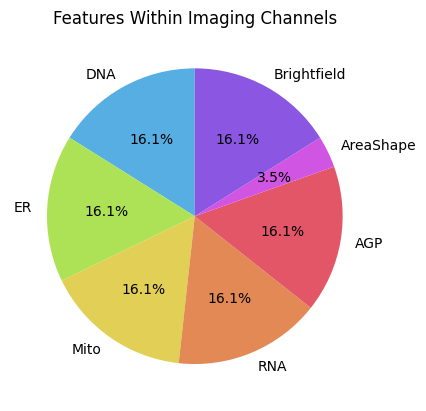

In [12]:
# how many features do we identify from each of our imaging channels?
data_by_well_D28 = data_by_well[data_by_well.index.str.contains('D28')]
all_features = data_by_well_D28.columns.tolist()
dna_ch = [i for i in all_features if 'DNA' in i[-20:]]
er_ch = [i for i in all_features if 'ER' in i[-20:]]
mito_ch = [i for i in all_features if 'Mito' in i[-20:]]
rna_ch = [i for i in all_features if 'RNA' in i[-20:]]
agp_ch = [i for i in all_features if 'AGP' in i[-20:]]
areashape = [i for i in all_features if 'AreaShape' in i]
brightfield = [i for i in all_features if 'Brightfield' in i]
labels = ['DNA', 'ER', 'Mito', 'RNA', 'AGP', 'AreaShape', 'Brightfield']
sizes = [len(dna_ch), len(er_ch), len(mito_ch), len(rna_ch), len(agp_ch), len(areashape), len(brightfield)]
fig1, ax1 = plt.subplots()
colors = ['#56AEE2', '#AEE256', '#E2CF56', '#E28956', '#E25668', '#D055E2', '#8A56E2', '#E2CF56']
# colors = ['b', 'darkgrey', 'magenta', 'brown', 'purple', 'r', 'g', 'orange']
ax1.pie(sizes, labels=labels, autopct='%1.1f%%', colors=colors,
        shadow=False, startangle=90)
ax1.set_title("Features Within Imaging Channels")
plt.show()

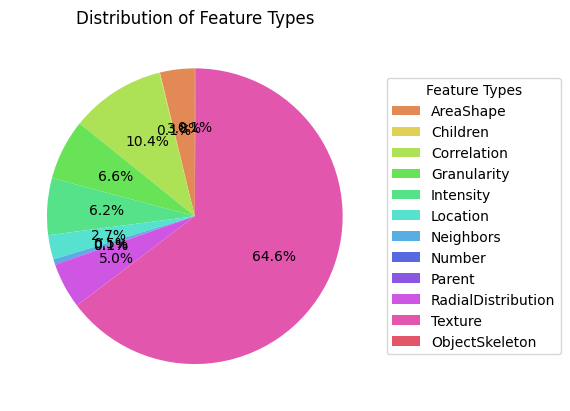

[165, 3, 450, 288, 270, 116, 21, 3, 3, 216, 2808, 4] 4347


Counter({'AreaShape': 165,
         'Children': 3,
         'Correlation': 450,
         'Granularity': 288,
         'Intensity': 270,
         'Location': 116,
         'Neighbors': 21,
         'Number': 3,
         'Parent': 3,
         'RadialDistribution': 216,
         'Texture': 2808,
         'ObjectSkeleton': 4})

In [13]:
#What is the distribution of different feature types in data?
all_features = data_by_well.columns.tolist()
all_feature_types = [i.split('_')[1] for i in all_features]
all_feature_types = Counter(all_feature_types)
labels = []
sizes = []

fig1, ax1 = plt.subplots()
for x,y in all_feature_types.items():
    labels.append(x)
    sizes.append(y)
    
colors = ['#E28956','#E2CF56', '#AEE256', '#68E256', '#56E289', '#56E2CF', '#56AEE2', 
         '#5668E2', '#8A56E2', '#CF56E2', '#E256AE', "#E25668"]

ax1.pie(sizes, autopct='%1.1f%%', colors=colors,
        shadow=False, startangle=90)

ax1.set_title("Distribution of Feature Types")

ax1.legend(labels,
          title="Feature Types",
          loc="center left",
          bbox_to_anchor=(1, 0, 0.5, 1))

plt.show()
print(sizes,sum(sizes))
all_feature_types

## What does the NPC data look like?

In [14]:
from pathlib import Path
path = os.getcwd()
base_dir = str(Path(path).parent)

# Normalized data, not var selected
# data_by_well = load_data(base_dir + '/1.run-workflows/profiles/NCP_STEM_1/BR_NCP_STEM_1/BR_NCP_STEM_1_normalized.csv.gz')
# data_by_well = data_by_well.dropna(axis=1)

# Normalized var selected data, provided to me 
# data_by_well = load_data(base_dir + '/1.run-workflows/profiles/NCP_STEM_1/BR_NCP_STEM_1/BR_NCP_STEM_1_normalized_variable_selected.csv.gz')

# Or use my FS data
data_by_well = pd.read_csv(r"C:\Users\kboit\Documents\Thesis\NPC_WELL_AVG_CONCAT.csv", index_col=0)

data_by_well_orig = data_by_well.copy()

try:
    idx = [i for i in data_by_well.index.tolist() if i.split('_')[-1] not in exclude]
    data_by_well = data_by_well[data_by_well.index.isin(idx)]
except: pass

print ('shape: {}'.format(data_by_well.shape))

shape: (190, 4347)


In [15]:
data_by_well_NPC = data_by_well[data_by_well.index.str.contains('NPC')]

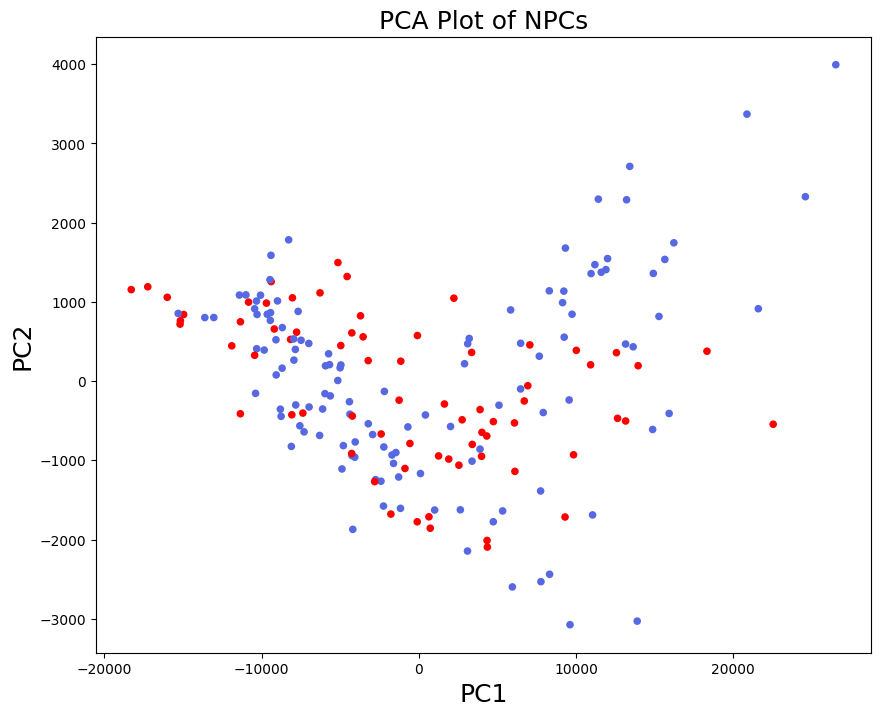

In [16]:
pca = PCA(n_components=2)
pca_fit = pca.fit(data_by_well)
pca_vals = pca_fit.transform(data_by_well)
pca_df = pd.DataFrame(pca_vals, columns=['PC1', 'PC2'], index=data_by_well.index)
idxs = [i.split('_')[0] + '_' + i.split('_')[1] for i in pca_df.index.tolist()]
idx2color = {'NPC_case': 'r', 'NPC_ctrl': '#5668E2'}
# NPC_case in red, NPC_ctrl in blue
colors = [idx2color[i] for i in idxs]
pca_df['color'] = colors

fig, ax = plt.subplots(figsize=(10,8))
pca_df.plot('PC1', 'PC2', kind='scatter', ax=ax, c='color')

plt.title('PCA Plot of NPCs', fontsize=18)
ax.xaxis.get_label().set_fontsize(18)
ax.yaxis.get_label().set_fontsize(18)

## Do the wells within each cell line correlate?

C:\Users\kboit\AppData\Local\Temp\ipykernel_8284\2627456486.py:10: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(ax.get_xticklabels(),rotation=90, fontsize = 25)


0.9960429777655234


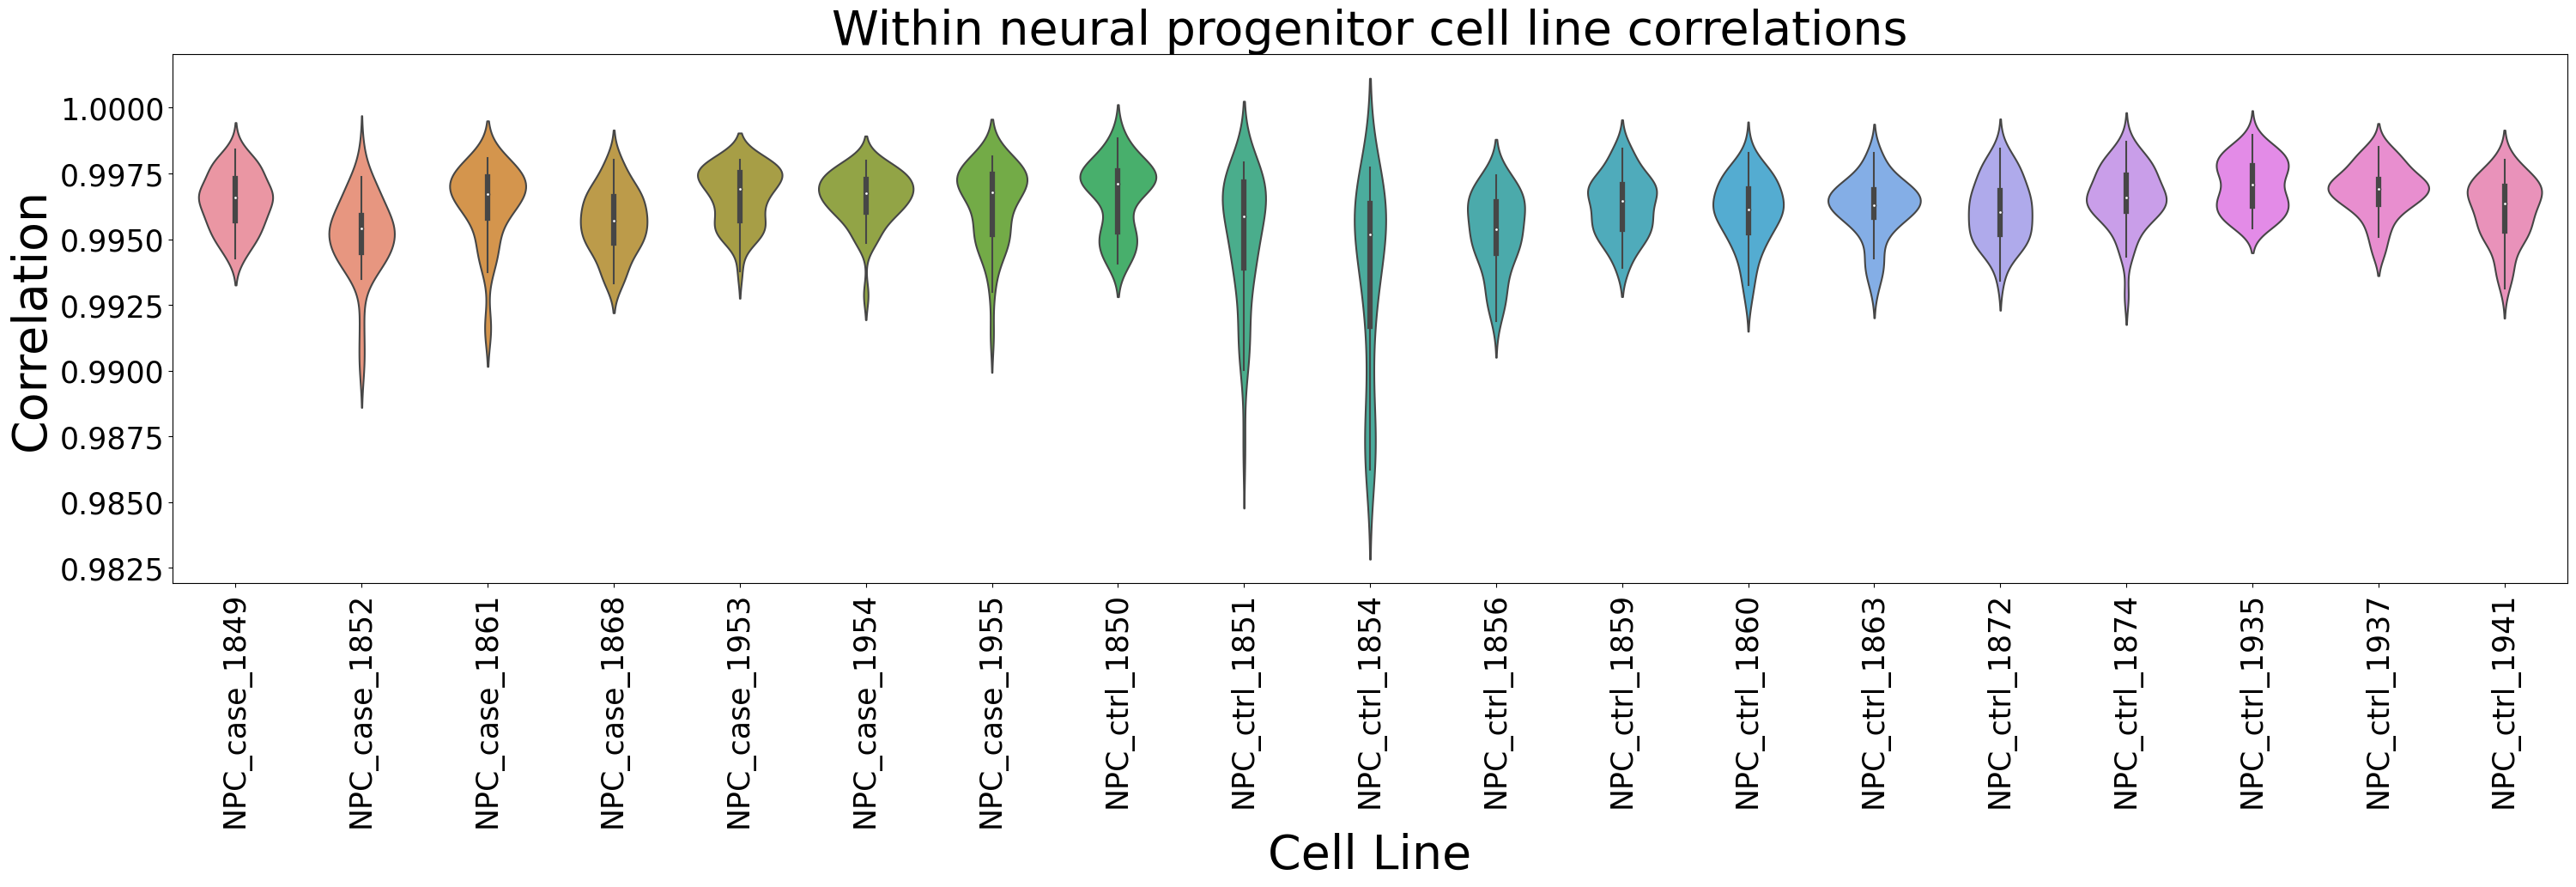

In [17]:
corrs = unstack_formatted_matrix(data_by_well)

# Get correlations within each cell line (10 replicates per)
corrs_within_line = corrs[corrs['cell_line1']==corrs['cell_line2']]

# Plot the self correlations
order = sorted(list(set(corrs_within_line['cell_line1'].tolist())))
fig, ax = plt.subplots(figsize=(36,8))
plt.title('Within neural progenitor cell line correlations', fontsize= 40)
ax.set_xticklabels(ax.get_xticklabels(),rotation=90, fontsize = 25)
ax = sns.violinplot(x='cell_line1', y='correlation', data=corrs_within_line, order=order)
plt.xlabel('Cell Line', fontsize = 40)
plt.ylabel('Correlation', fontsize = 40)
plt.yticks(fontsize = 25)

print(corrs_within_line['correlation'].mean())

## What are the differentiating features in NPCs?

In [18]:
## Differentiating features

NPC_case = data_by_well[data_by_well.index.str.contains('NPC_case')]
NPC_ctrl = data_by_well[data_by_well.index.str.contains('NPC_ctrl')]

NPC_diff = ttest_2_df(NPC_case, NPC_ctrl, alpha=0.001, reject_only=True).sort_values(by='adj_p_value', ascending=True)

print ('shape: {}'.format(NPC_diff.shape))

shape: (212, 3)


C:\Users\kboit\AppData\Local\Temp\ipykernel_8284\1117527299.py:6: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  z_score, pvals = ttest_ind(df1.values, df2.values, axis=0)


In [19]:
# What are the differential features in NPCs?

from IPython.display import display, HTML
display(HTML(NPC_diff.to_html()))

,pval,adj_p_value,reject_null
Cells_AreaShape_FormFactor,3.120811e-05,NaN,True
Cells_AreaShape_Zernike_4_0,8.560372e-06,NaN,True
Cells_Correlation_Costes_DNA_ER,4.720777e-05,NaN,True
Cells_Correlation_K_AGP_Brightfield,9.374024e-06,NaN,True
Cells_Correlation_Manders_Brightfield_AGP,3.782386e-07,NaN,True
Cells_Correlation_Manders_ER_AGP,5.679311e-06,NaN,True
Cells_Correlation_Manders_Mito_AGP,6.356780e-08,NaN,True
Cells_Correlation_Manders_RNA_AGP,3.958310e-08,NaN,True
Cells_Correlation_Overlap_Brightfield_AGP,1.407508e-08,NaN,True
Cells_Correlation_Overlap_DNA_Mito,1.550773e-07,NaN,True


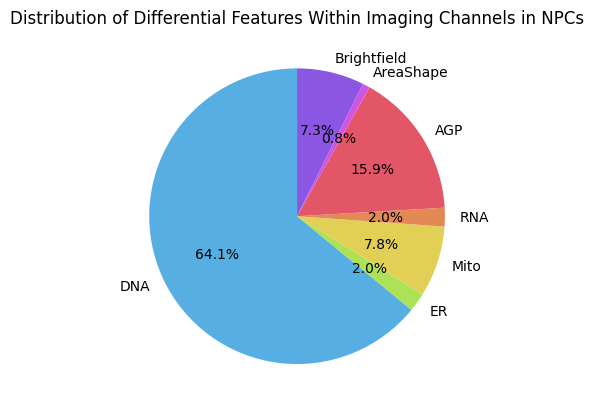

In [23]:
## What is the distribution of features we identify from each of our imaging channels?

diff = [i for i in NPC_diff.index.tolist()]
NPC_features = diff
dna_ch = [i for i in NPC_features if 'DNA' in i[-20:]]
er_ch = [i for i in NPC_features if 'ER' in i[-20:]]
mito_ch = [i for i in NPC_features if 'Mito' in i[-20:]]
rna_ch = [i for i in NPC_features if 'RNA' in i[-20:]]
agp_ch = [i for i in NPC_features if 'AGP' in i[-20:]]
areashape = [i for i in NPC_features if 'AreaShape' in i]
brightfield = [i for i in NPC_features if 'Brightfield' in i]
labels = ['DNA', 'ER', 'Mito', 'RNA', 'AGP', 'AreaShape', 'Brightfield']
sizes = [len(dna_ch), len(er_ch), len(mito_ch), len(rna_ch), len(agp_ch), len(areashape), len(brightfield)]
fig1, ax1 = plt.subplots()
colors = ['#56AEE2', '#AEE256', '#E2CF56', '#E28956', '#E25668', '#D055E2', '#8A56E2', '#E2CF56']
# colors = ['b', 'darkgrey', 'magenta', 'brown', 'purple', 'r', 'g', 'orange']
ax1.set_title("Distribution of Differential Features Within Imaging Channels in NPCs")
ax1.pie(sizes, labels=labels, autopct='%1.1f%%', colors=colors,
        shadow=False, startangle=90)
plt.show()

In [24]:
NPC_test = [i for i in NPC_diff.index.tolist()]

NPC_feature_types0 = [i.split('_')[0] for i in NPC_test]
NPC_feature_types0 = Counter(NPC_feature_types0)
NPC_feature_types1 = [i.split('_')[1] for i in NPC_test]
NPC_feature_types1 = Counter(NPC_feature_types1)

print(NPC_feature_types0)
print(NPC_feature_types1)

Counter({'Cytoplasm': 119, 'Cells': 59, 'Nuclei': 34})
Counter({'Texture': 143, 'Correlation': 33, 'Granularity': 15, 'Intensity': 10, 'RadialDistribution': 9, 'AreaShape': 2})


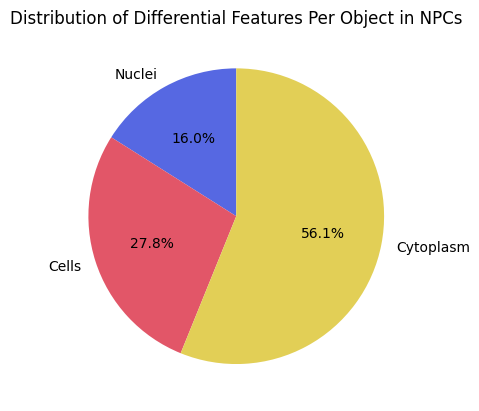

In [25]:
# Distribution of differential features in objects
# 'Cytoplasm': 119, 'Cells': 59, 'Nuclei': 34})
labels = ['Nuclei', 'Cells', 'Cytoplasm']
sizes = [34, 59, 119]
fig1, ax1 = plt.subplots()
colors = ['#5668E2', '#E25668', '#E2CF56']
ax1.pie(sizes, labels=labels, autopct='%1.1f%%', colors=colors,
        shadow=False, startangle=90)
ax1.set_title("Distribution of Differential Features Per Object in NPCs")
plt.show()

## What does the D14 neuron data look like?

In [26]:
from pathlib import Path
path = os.getcwd()
base_dir = str(Path(path).parent)

# Normalized data, not var selected
# data_by_well = load_data(base_dir + '/1.run-workflows/profiles/NCP_STEM_1/BR_NCP_STEM_1/BR_NCP_STEM_1_normalized.csv.gz')
# data_by_well = data_by_well.dropna(axis=1)

# Normalized var selected data, provided to me 
# data_by_well = load_data(base_dir + '/1.run-workflows/profiles/NCP_STEM_1/BR_NCP_STEM_1/BR_NCP_STEM_1_normalized_variable_selected.csv.gz')

# Or use my FS data
data_by_well = pd.read_csv(r"C:\Users\kboit\Documents\Thesis\D14_WELL_AVG_CONCAT.csv", index_col=0)

data_by_well_orig = data_by_well.copy()

try:
    idx = [i for i in data_by_well.index.tolist() if i.split('_')[-1] not in exclude]
    data_by_well = data_by_well[data_by_well.index.isin(idx)]
except: pass

print ('shape: {}'.format(data_by_well.shape))

shape: (170, 4347)


In [27]:
data_by_well_D14 = data_by_well[data_by_well.index.str.contains('D14')]

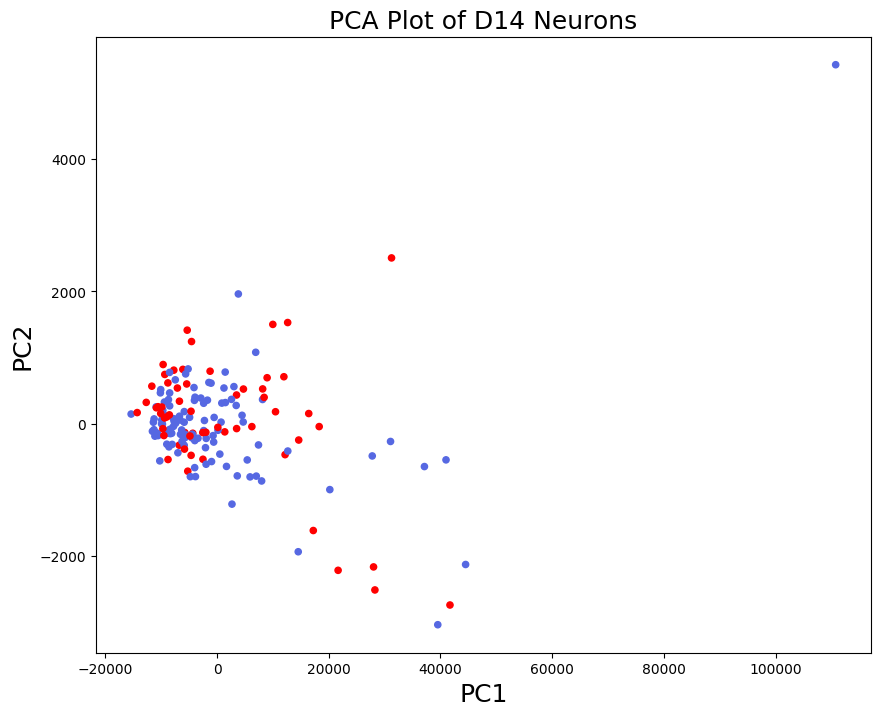

In [28]:
pca = PCA(n_components=2)
pca_fit = pca.fit(data_by_well)
pca_vals = pca_fit.transform(data_by_well)
pca_df = pd.DataFrame(pca_vals, columns=['PC1', 'PC2'], index=data_by_well.index)
idxs = [i.split('_')[0] + '_' + i.split('_')[1] for i in pca_df.index.tolist()]
idx2color = {'D14_case': 'red', 'D14_ctrl': '#5668E2'}
# D14_case in red #E25668, D14_ctrl in blue
colors = [idx2color[i] for i in idxs]
pca_df['color'] = colors

fig, ax = plt.subplots(figsize=(10,8))
pca_df.plot('PC1', 'PC2', kind='scatter', ax=ax, c='color')

plt.title('PCA Plot of D14 Neurons', fontsize=18)
ax.xaxis.get_label().set_fontsize(18)
ax.yaxis.get_label().set_fontsize(18)

## Do the wells within each cell line correlate?

C:\Users\kboit\AppData\Local\Temp\ipykernel_8284\994100569.py:10: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(ax.get_xticklabels(),rotation=90, fontsize = 25)


0.9953455573861181


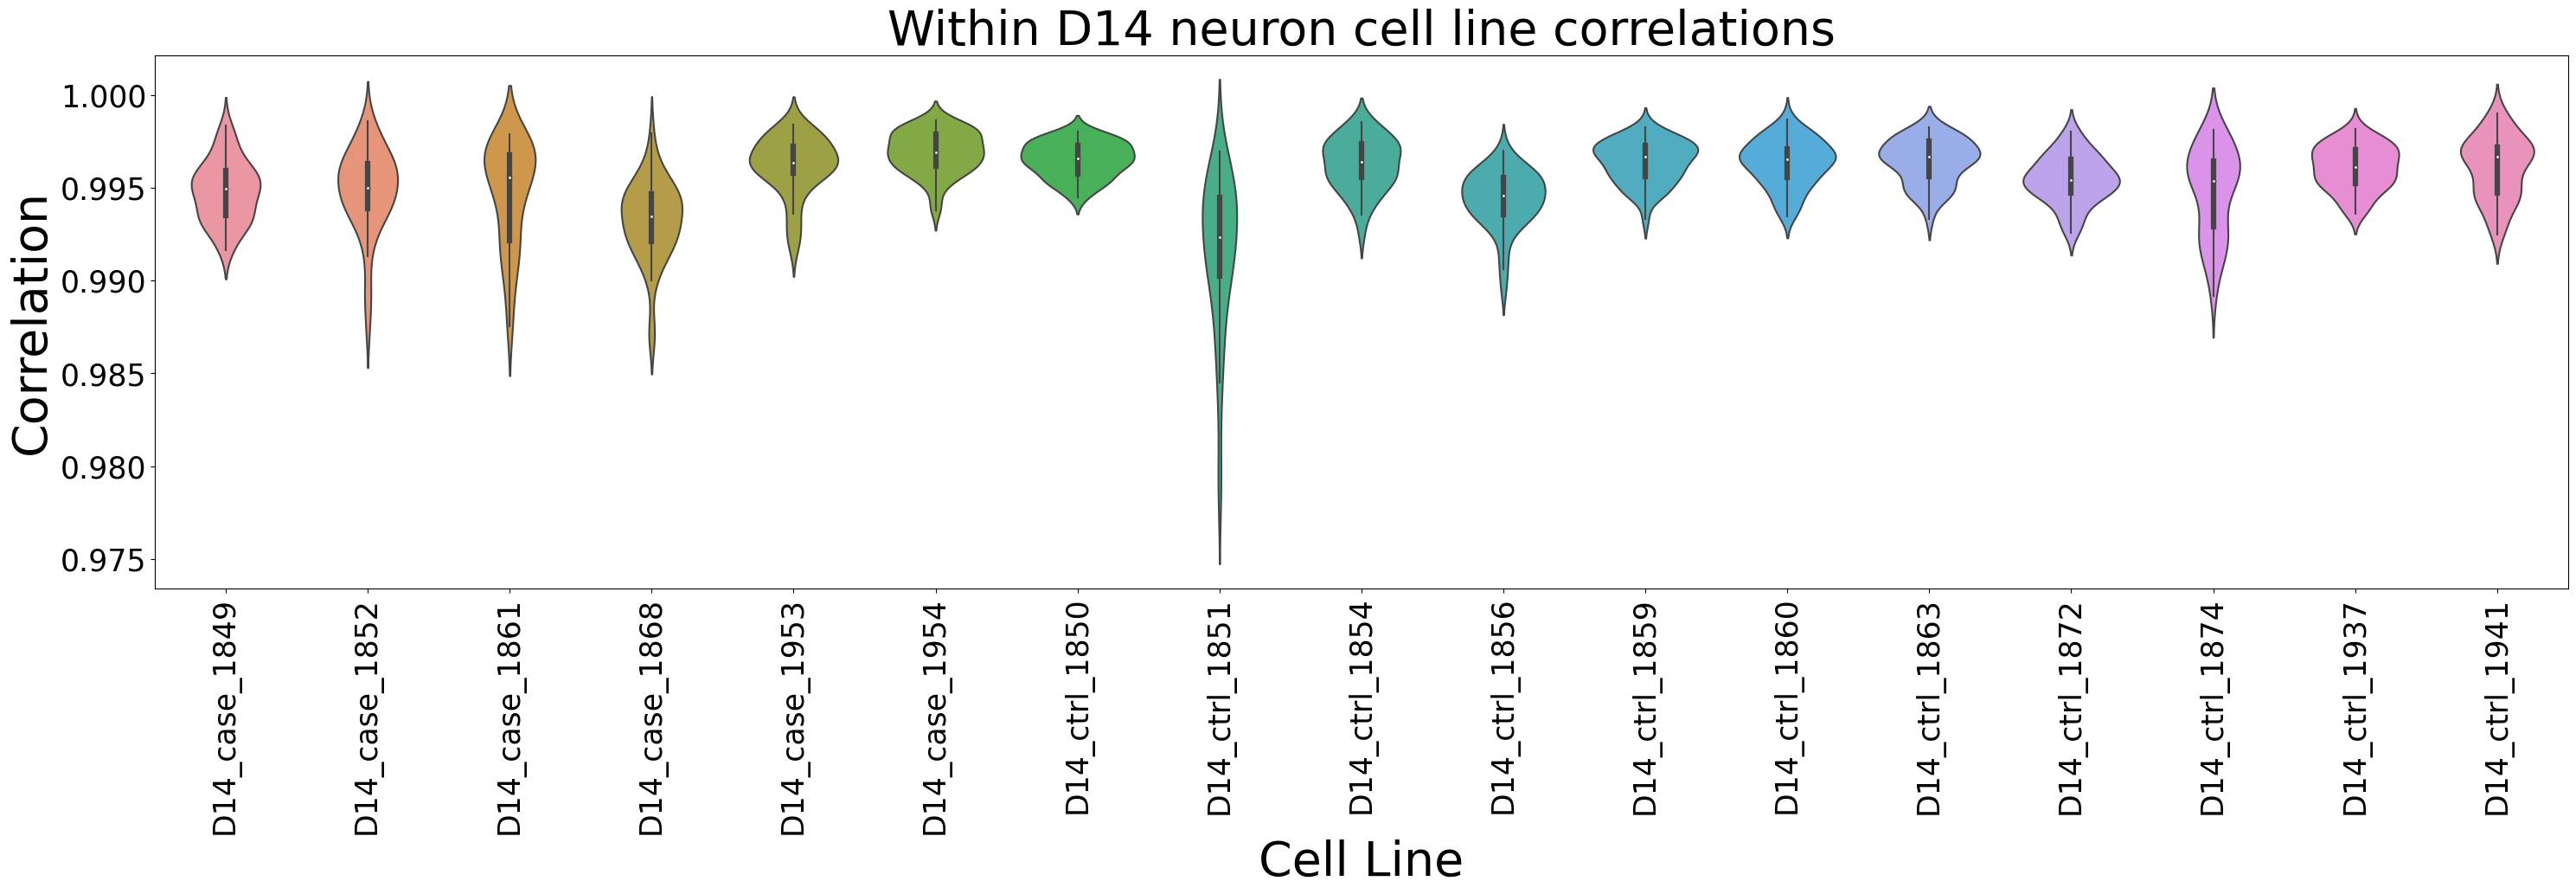

In [29]:
corrs = unstack_formatted_matrix(data_by_well)

# Get correlations within each cell line (10 replicates per)
corrs_within_line = corrs[corrs['cell_line1']==corrs['cell_line2']]

# Plot the self correlations
order = sorted(list(set(corrs_within_line['cell_line1'].tolist())))
fig, ax = plt.subplots(figsize=(36,8))
plt.title('Within D14 neuron cell line correlations', fontsize= 40)
ax.set_xticklabels(ax.get_xticklabels(),rotation=90, fontsize = 25)
ax = sns.violinplot(x='cell_line1', y='correlation', data=corrs_within_line, order=order)
plt.xlabel('Cell Line', fontsize = 40)
plt.ylabel('Correlation', fontsize = 40)
plt.yticks(fontsize = 25)

print(corrs_within_line['correlation'].mean())

## What are the differentiating features in D14 neurons?

In [30]:
## Differentiating features

D14_case = data_by_well[data_by_well.index.str.contains('D14_case')]
D14_ctrl = data_by_well[data_by_well.index.str.contains('D14_ctrl')]

# Find features different between cases and controls

D14_diff = ttest_2_df(D14_case, D14_ctrl, alpha=0.001, reject_only=True).sort_values(by='adj_p_value', ascending=True)

print ('shape: {}'.format(D14_diff.shape))

shape: (403, 3)


C:\Users\kboit\AppData\Local\Temp\ipykernel_8284\1117527299.py:6: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  z_score, pvals = ttest_ind(df1.values, df2.values, axis=0)


In [31]:
# What are the differential features in D14 neurons?

display(HTML(D14_diff.to_html()))

,pval,adj_p_value,reject_null
Cells_AreaShape_MaximumRadius,1.616988e-06,NaN,True
Cells_AreaShape_MeanRadius,4.545620e-07,NaN,True
Cells_AreaShape_MedianRadius,1.043785e-06,NaN,True
Cells_Correlation_Correlation_AGP_Brightfield,6.198682e-05,NaN,True
Cells_Correlation_Correlation_AGP_Mito,8.283632e-06,NaN,True
Cells_Correlation_Correlation_DNA_Brightfield,1.136722e-05,NaN,True
Cells_Correlation_Correlation_DNA_Mito,7.190664e-05,NaN,True
Cells_Correlation_Correlation_ER_Brightfield,2.284709e-05,NaN,True
Cells_Correlation_Correlation_ER_Mito,6.430056e-08,NaN,True
Cells_Correlation_Correlation_Mito_Brightfield,3.588745e-12,NaN,True


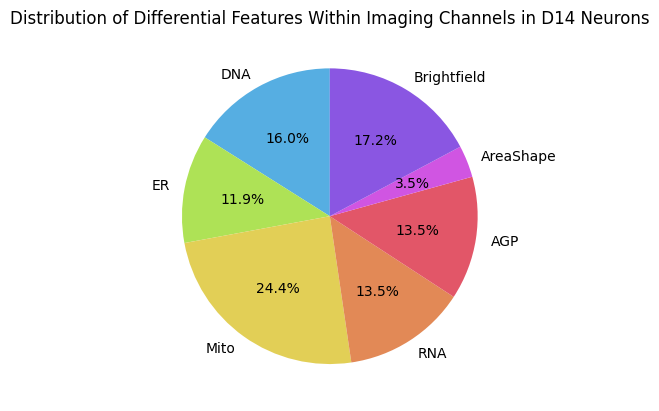

In [33]:
## how many different features do we identify from each of our imaging channels?
diff = [i for i in D14_diff.index.tolist()]
D14_features = diff
dna_ch = [i for i in D14_features if 'DNA' in i[-20:]]
er_ch = [i for i in D14_features if 'ER' in i[-20:]]
mito_ch = [i for i in D14_features if 'Mito' in i[-20:]]
rna_ch = [i for i in D14_features if 'RNA' in i[-20:]]
agp_ch = [i for i in D14_features if 'AGP' in i[-20:]]
areashape = [i for i in D14_features if 'AreaShape' in i]
brightfield = [i for i in D14_features if 'Brightfield' in i]
labels = ['DNA', 'ER', 'Mito', 'RNA', 'AGP', 'AreaShape', 'Brightfield']
sizes = [len(dna_ch), len(er_ch), len(mito_ch), len(rna_ch), len(agp_ch), len(areashape), len(brightfield)]
fig1, ax1 = plt.subplots()
colors = ['#56AEE2', '#AEE256', '#E2CF56', '#E28956', '#E25668', '#D055E2', '#8A56E2', '#E2CF56']
# colors = ['b', 'darkgrey', 'magenta', 'brown', 'purple', 'r', 'g', 'orange']
ax1.pie(sizes, labels=labels, autopct='%1.1f%%', colors=colors,
        shadow=False, startangle=90)
ax1.set_title("Distribution of Differential Features Within Imaging Channels in D14 Neurons")

plt.show()

In [34]:
D14_test = [i for i in D14_diff.index.tolist()]

D14_feature_types0 = [i.split('_')[0] for i in D14_test]
D14_feature_types0 = Counter(D14_feature_types0)
D14_feature_types1 = [i.split('_')[1] for i in D14_test]
D14_feature_types1 = Counter(D14_feature_types1)

print(D14_feature_types0)
print(D14_feature_types1)

Counter({'Nuclei': 346, 'Cells': 40, 'Cytoplasm': 17})
Counter({'Texture': 309, 'Granularity': 34, 'Correlation': 27, 'AreaShape': 15, 'RadialDistribution': 14, 'Intensity': 4})


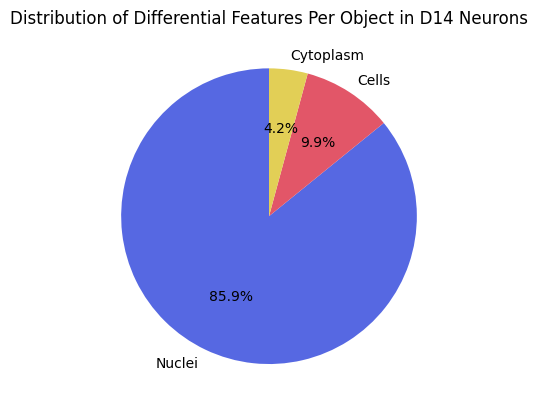

In [35]:
# Distribution of objects in D14s 
# 'Nuclei': 346, 'Cells': 40, 'Cytoplasm': 17
labels = ['Nuclei', 'Cells', 'Cytoplasm']
sizes = [346, 40, 17]
fig1, ax1 = plt.subplots()
colors = ['#5668E2','#E25668','#E2CF56']
ax1.pie(sizes, labels=labels, autopct='%1.1f%%', colors=colors,
        shadow=False, startangle=90)
ax1.set_title("Distribution of Differential Features Per Object in D14 Neurons")
plt.show()

## Finally, let's look at the D28 neurons!

In [36]:
from pathlib import Path
path = os.getcwd()
base_dir = str(Path(path).parent)

# Normalized data, not var selected
# data_by_well = load_data(base_dir + '/1.run-workflows/profiles/NCP_STEM_1/BR_NCP_STEM_1/BR_NCP_STEM_1_normalized.csv.gz')
# data_by_well = data_by_well.dropna(axis=1)

# Normalized var selected data, provided to me 
# data_by_well = load_data(base_dir + '/1.run-workflows/profiles/NCP_STEM_1/BR_NCP_STEM_1/BR_NCP_STEM_1_normalized_variable_selected.csv.gz')

# Or use my FS data
data_by_well = pd.read_csv(r"C:\Users\kboit\Documents\Thesis\D28_WELL_AVG_CONCAT.csv", index_col=0)

data_by_well_orig = data_by_well.copy()

try:
    idx = [i for i in data_by_well.index.tolist() if i.split('_')[-1] not in exclude]
    data_by_well = data_by_well[data_by_well.index.isin(idx)]
except: pass

print ('shape: {}'.format(data_by_well.shape))

shape: (190, 4347)


In [37]:
data_by_well_D28 = data_by_well[data_by_well.index.str.contains('D28')]

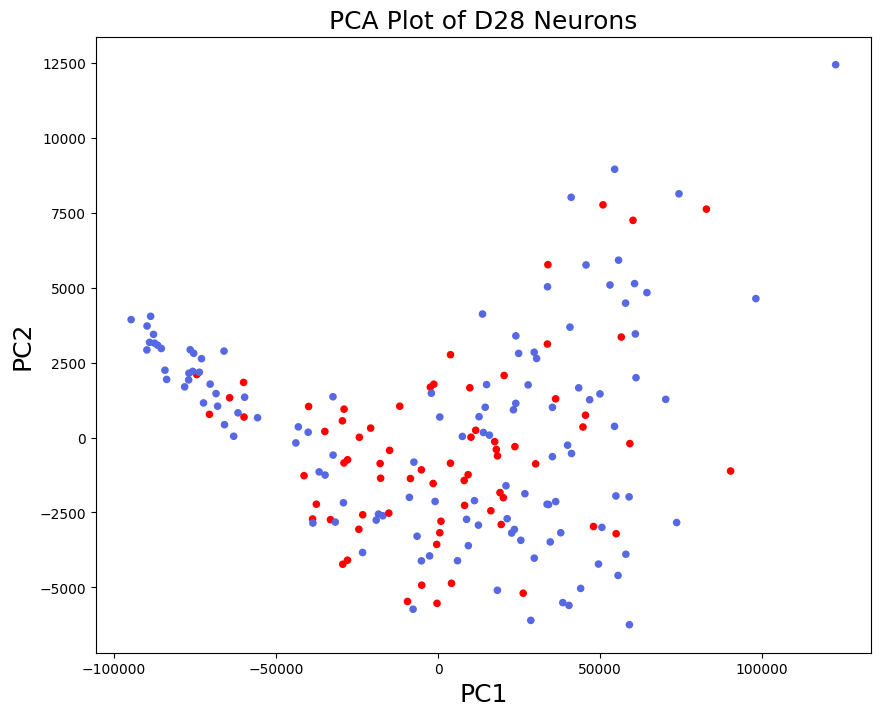

In [38]:
pca = PCA(n_components=2)
pca_fit = pca.fit(data_by_well)
pca_vals = pca_fit.transform(data_by_well)
pca_df = pd.DataFrame(pca_vals, columns=['PC1', 'PC2'], index=data_by_well_D28.index)
idxs = [i.split('_')[0] + '_' + i.split('_')[1] for i in pca_df.index.tolist()]
idx2color = {'D28_case': 'red', 'D28_ctrl': '#5668E2'}
# D14_case in red, D14_ctrl in blue
colors = [idx2color[i] for i in idxs]
pca_df['color'] = colors

fig, ax = plt.subplots(figsize=(10,8))
pca_df.plot('PC1', 'PC2', kind='scatter', ax=ax, c='color')

plt.title('PCA Plot of D28 Neurons', fontsize=18)
ax.xaxis.get_label().set_fontsize(18)
ax.yaxis.get_label().set_fontsize(18)

## Do the wells within each cell line correlate?

C:\Users\kboit\AppData\Local\Temp\ipykernel_8284\2059761061.py:10: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(ax.get_xticklabels(),rotation=90, fontsize = 25)


0.9938608116763895


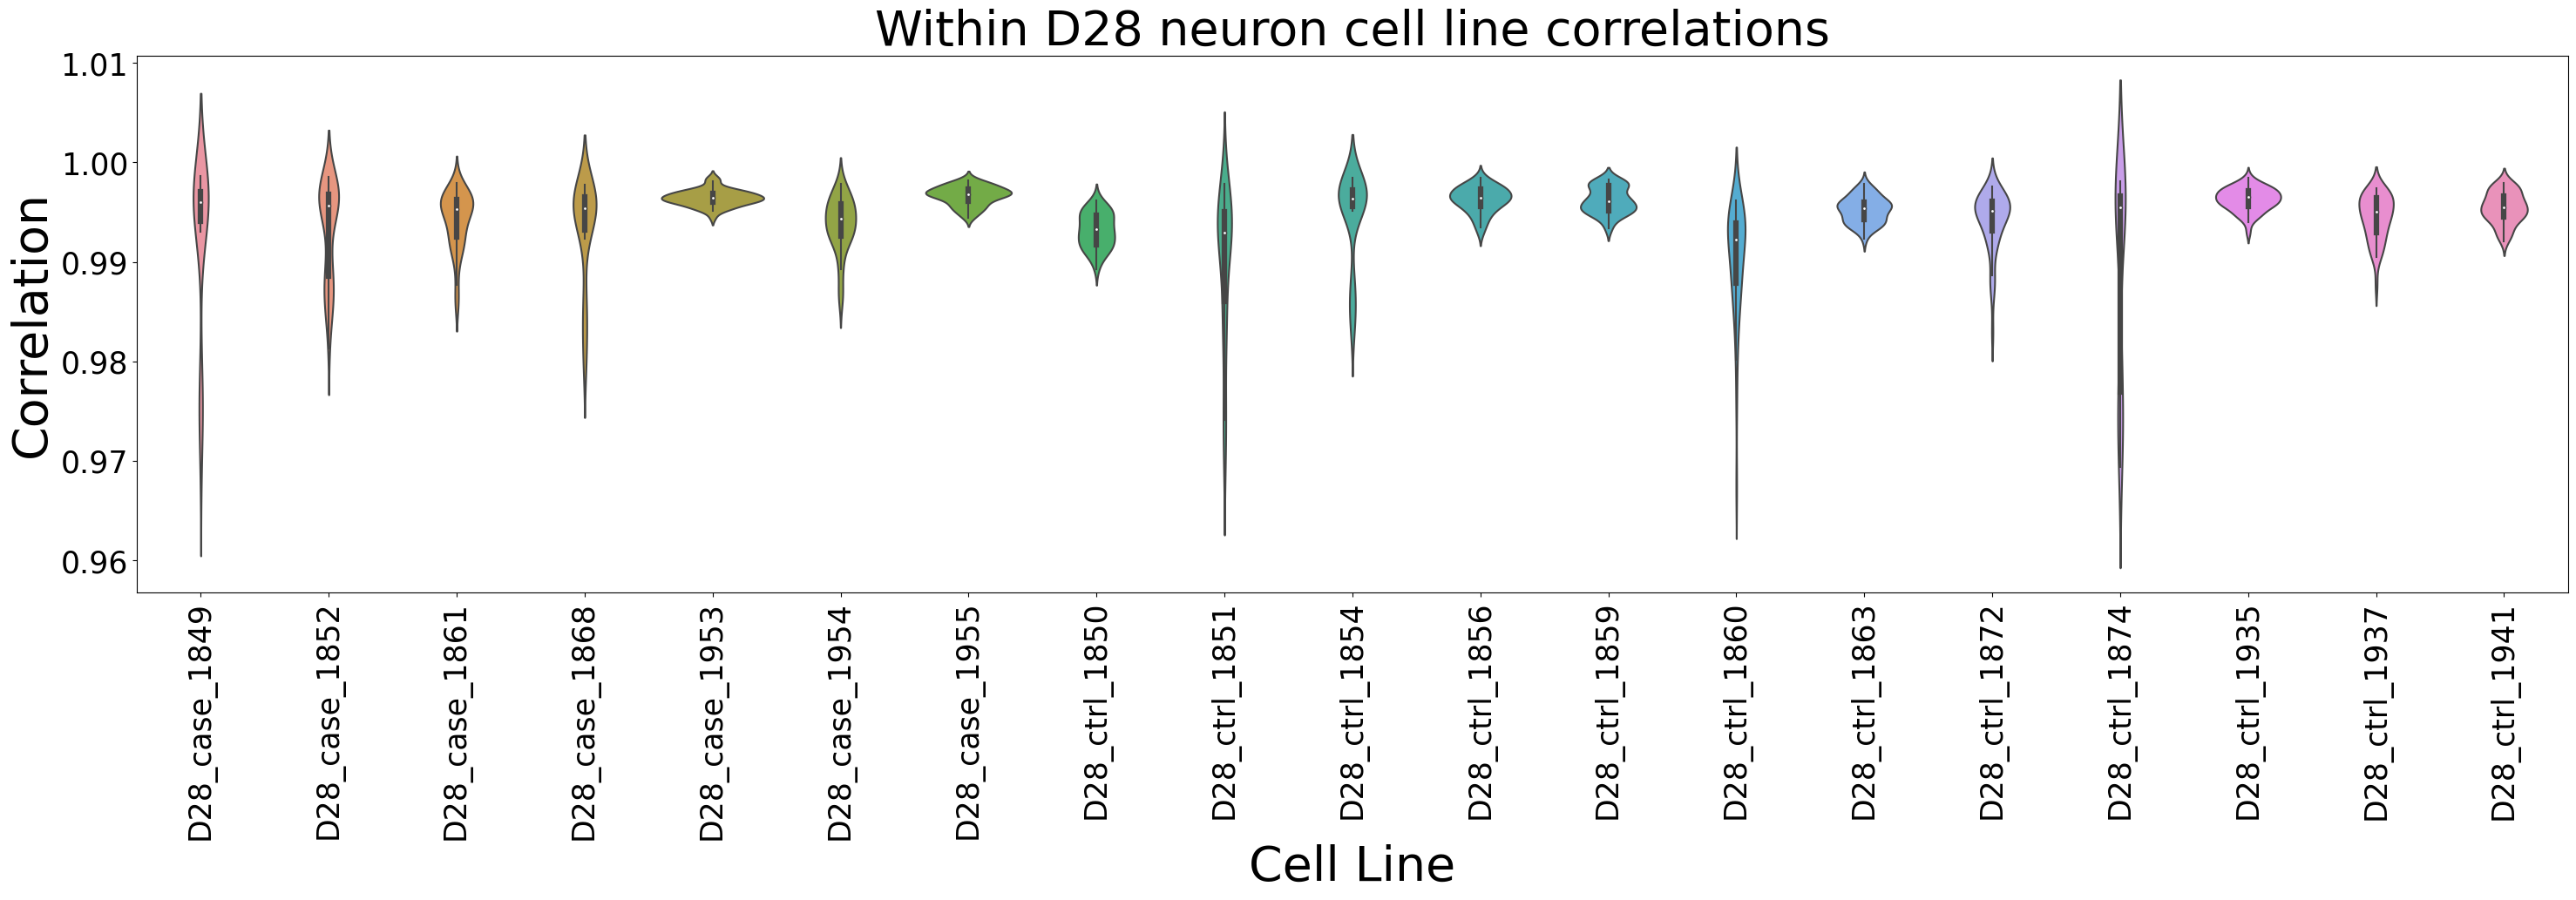

In [39]:
corrs = unstack_formatted_matrix(data_by_well)

# Get correlations within each cell line (10 replicates per)
corrs_within_line = corrs[corrs['cell_line1']==corrs['cell_line2']]

# Plot the self correlations
order = sorted(list(set(corrs_within_line['cell_line1'].tolist())))
fig, ax = plt.subplots(figsize=(36,8))
plt.title('Within D28 neuron cell line correlations', fontsize= 40)
ax.set_xticklabels(ax.get_xticklabels(),rotation=90, fontsize = 25)
ax = sns.violinplot(x='cell_line1', y='correlation', data=corrs_within_line, order=order)
plt.xlabel('Cell Line', fontsize = 40)
plt.ylabel('Correlation', fontsize = 40)
plt.yticks(fontsize = 25)

print(corrs_within_line['correlation'].mean())

## What are the differentiating features in D28 neurons?

In [40]:
## Differentiating features

D28_case = data_by_well[data_by_well.index.str.contains('D28_case')]
D28_ctrl = data_by_well[data_by_well.index.str.contains('D28_ctrl')]

# Find features different between cases and controls

D28_diff = ttest_2_df(D28_case, D28_ctrl, alpha=0.001, reject_only=True).sort_values(by='adj_p_value', ascending=True)

print ('shape: {}'.format(D28_diff.shape))

shape: (343, 3)


C:\Users\kboit\AppData\Local\Temp\ipykernel_8284\1117527299.py:6: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  z_score, pvals = ttest_ind(df1.values, df2.values, axis=0)


In [41]:
# What are the differential features in D28 neurons?

display(HTML(D28_diff.to_html()))

,pval,adj_p_value,reject_null
Cells_Correlation_Correlation_Mito_AGP,7.544247e-05,NaN,True
Cells_Correlation_K_Brightfield_Mito,9.192353e-06,NaN,True
Cells_Correlation_K_DNA_Mito,1.989600e-05,NaN,True
Cells_Correlation_K_Mito_AGP,3.144989e-05,NaN,True
Cells_Correlation_K_Mito_Brightfield,9.379303e-06,NaN,True
Cells_Granularity_3_AGP,2.006791e-05,NaN,True
Cells_Granularity_3_ER,3.643218e-05,NaN,True
Cells_Intensity_MADIntensity_Mito,4.690078e-08,NaN,True
Cells_Intensity_MaxIntensityEdge_Mito,9.164782e-06,NaN,True
Cells_Intensity_MinIntensityEdge_Brightfield,3.764509e-05,NaN,True


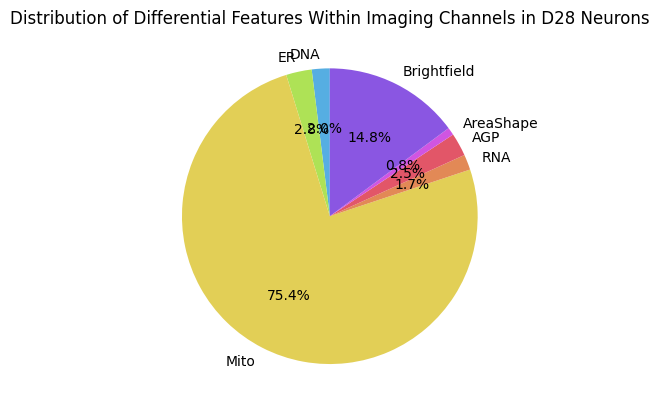

In [46]:
## how many different features do we identify from each of our imaging channels?
diff = [i for i in D28_diff.index.tolist()]
D28_features = diff
dna_ch = [i for i in D28_features if 'DNA' in i[-20:]]
er_ch = [i for i in D28_features if 'ER' in i[-20:]]
mito_ch = [i for i in D28_features if 'Mito' in i[-20:]]
rna_ch = [i for i in D28_features if 'RNA' in i[-20:]]
agp_ch = [i for i in D28_features if 'AGP' in i[-20:]]
areashape = [i for i in D28_features if 'AreaShape' in i]
brightfield = [i for i in D28_features if 'Brightfield' in i]
labels = ['DNA', 'ER', 'Mito', 'RNA', 'AGP', 'AreaShape', 'Brightfield']
sizes = [len(dna_ch), len(er_ch), len(mito_ch), len(rna_ch), len(agp_ch), len(areashape), len(brightfield)]
fig1, ax1 = plt.subplots()
colors = ['#56AEE2', '#AEE256', '#E2CF56', '#E28956', '#E25668', '#D055E2', '#8A56E2', '#E2CF56']
# colors = ['b', 'darkgrey', 'magenta', 'brown', 'purple', 'r', 'g', 'orange']
ax1.pie(sizes, labels=labels, autopct='%1.1f%%', colors=colors,
        shadow=False, startangle=90)
ax1.set_title("Distribution of Differential Features Within Imaging Channels in D28 Neurons")

plt.show()

In [47]:
D28_test = [i for i in D28_diff.index.tolist()]

D28_feature_types0 = [i.split('_')[0] for i in D28_test]
D28_feature_types0 = Counter(D28_feature_types0)
D28_feature_types1 = [i.split('_')[1] for i in D28_test]
D28_feature_types1 = Counter(D28_feature_types1)

print(D28_feature_types0)
print(D28_feature_types1)

Counter({'Nuclei': 130, 'Cytoplasm': 113, 'Cells': 100})
Counter({'Texture': 288, 'Intensity': 23, 'Correlation': 14, 'Granularity': 8, 'RadialDistribution': 7, 'AreaShape': 3})


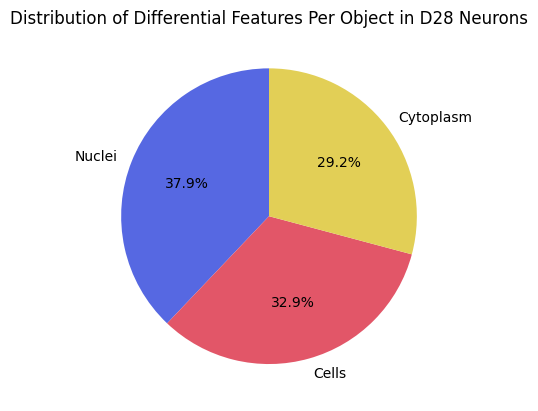

In [48]:
# Distribution of objects in D28s 
# {'Nuclei': 130, 'Cytoplasm': 113, 'Cells': 100}
labels = ['Nuclei', 'Cells', 'Cytoplasm']
sizes = [130, 113, 100]
fig1, ax1 = plt.subplots()
colors = ['#5668E2','#E25668','#E2CF56']
ax1.pie(sizes, labels=labels, autopct='%1.1f%%', colors=colors,
        shadow=False, startangle=90)
ax1.set_title("Distribution of Differential Features Per Object in D28 Neurons")
plt.show()

## Now let's compare the different cell types

In [49]:
from pathlib import Path
path = os.getcwd()
base_dir = str(Path(path).parent)

# Normalized data, not var selected
# data_by_well = load_data(base_dir + '/1.run-workflows/profiles/NCP_STEM_1/BR_NCP_STEM_1/BR_NCP_STEM_1_normalized.csv.gz')
# data_by_well = data_by_well.dropna(axis=1)

# Normalized var selected data, provided to me 
# data_by_well = load_data(base_dir + '/1.run-workflows/profiles/NCP_STEM_1/BR_NCP_STEM_1/BR_NCP_STEM_1_normalized_variable_selected.csv.gz')

# Or use my FS data
data_by_well = pd.read_csv(r"C:\Users\kboit\Documents\Thesis\ALL_WELL_AVG_CONCAT.csv", index_col=0)

data_by_well_orig = data_by_well.copy()

try:
    idx = [i for i in data_by_well.index.tolist() if i.split('_')[-1] not in exclude]
    data_by_well = data_by_well[data_by_well.index.isin(idx)]
except: pass

print ('shape: {}'.format(data_by_well.shape))

shape: (550, 4347)


<AxesSubplot: title={'center': 'PCA Plot of Neural Cell Types'}, xlabel='PC1', ylabel='PC2'>

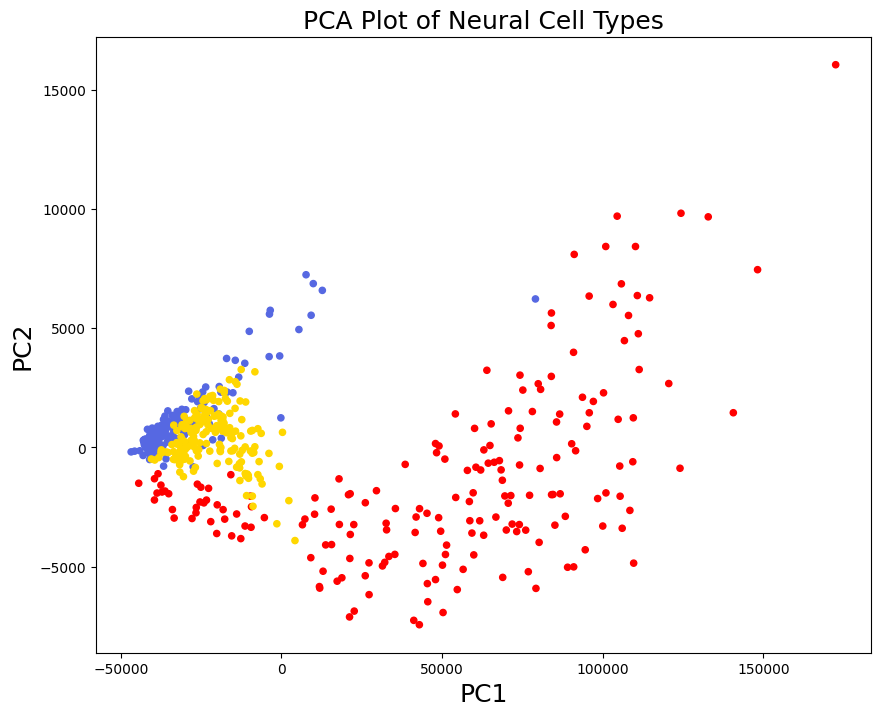

In [50]:
pca = PCA(n_components=2)
pca_fit = pca.fit(data_by_well)
pca_vals = pca_fit.transform(data_by_well)
pca_df = pd.DataFrame(pca_vals, columns=['PC1', 'PC2'], index=data_by_well.index)
idxs = [i.split('_')[0] + '_' + i.split('_')[1] for i in pca_df.index.tolist()]
idx2color = {'D28_ctrl': 'r', 'D14_ctrl': '#5668E2', 'NPC_ctrl': 'gold','D28_case': 'r', 'D14_case': '#5668E2', 'NPC_case': 'gold'}
colors = [idx2color[i] for i in idxs]
pca_df['color'] = colors

fig, ax = plt.subplots(figsize=(10,8))
plt.title('PCA Plot of Neural Cell Types', fontsize=18)
ax.xaxis.get_label().set_fontsize(18)
ax.yaxis.get_label().set_fontsize(18)

pca_df.plot('PC1', 'PC2', kind='scatter', ax=ax, c='color')

## What features differ between controls and cases?

In [51]:
D28_ctrl = data_by_well[data_by_well.index.str.contains('D28_ctrl')]
D28_case = data_by_well[data_by_well.index.str.contains('D28_case')]
D14_ctrl = data_by_well[data_by_well.index.str.contains('D14_ctrl')]
D14_case = data_by_well[data_by_well.index.str.contains('D14_case')]
NPC_case = data_by_well[data_by_well.index.str.contains('NPC_case')]
NPC_ctrl = data_by_well[data_by_well.index.str.contains('NPC_ctrl')]

# Find features different between cases and controls in different cell types
D28_diff = ttest_2_df(D28_case, D28_ctrl, alpha=0.001, reject_only=True).sort_values(by='adj_p_value', ascending=True)
D14_diff = ttest_2_df(D14_case, D14_ctrl, alpha=0.001, reject_only=True).sort_values(by='adj_p_value', ascending=True)
NPC_diff = ttest_2_df(NPC_case, NPC_ctrl, alpha=0.001, reject_only=True).sort_values(by='adj_p_value', ascending=True)
print ('shape: {}'.format(NPC_diff.shape))
print ('shape: {}'.format(D14_diff.shape))
print ('shape: {}'.format(D28_diff.shape))

shape: (212, 3)
shape: (403, 3)
shape: (343, 3)


C:\Users\kboit\AppData\Local\Temp\ipykernel_8284\1117527299.py:6: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  z_score, pvals = ttest_ind(df1.values, df2.values, axis=0)
C:\Users\kboit\AppData\Local\Temp\ipykernel_8284\1117527299.py:6: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  z_score, pvals = ttest_ind(df1.values, df2.values, axis=0)
C:\Users\kboit\AppData\Local\Temp\ipykernel_8284\1117527299.py:6: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  z_score, pvals = ttest_ind(df1.values, df2.values, axis=0)


In [59]:
D28_only = [i for i in D28_diff.index.tolist() if i not in D14_diff.index.tolist()]
D14_only = [i for i in D14_diff.index.tolist() if i not in D28_diff.index.tolist()]
NPC_only = [i for i in NPC_diff.index.tolist() if i not in D28_diff.index.tolist()]
all_shared = [i for i in D28_diff.index.tolist() if i in D14_diff.index.tolist() if i in NPC_diff.index.tolist()]
NPC_D14_shared = [i for i in NPC_diff.index.tolist() if i in D14_diff.index.tolist()]
NPC_D28_shared = [i for i in NPC_diff.index.tolist() if i in D28_diff.index.tolist()]
D14_D28_shared = [i for i in D14_diff.index.tolist() if i in D28_diff.index.tolist()]

print (len(NPC_only))
print(len(D14_only))
print(len(D28_only))
print(len(all_shared))

206
330
270
6


## What features do the cell types share?

In [60]:
#Import libraries
from matplotlib_venn import venn2, venn2_circles, venn2_unweighted
from matplotlib_venn import venn3, venn3_circles
from matplotlib import pyplot as plt
%matplotlib inline

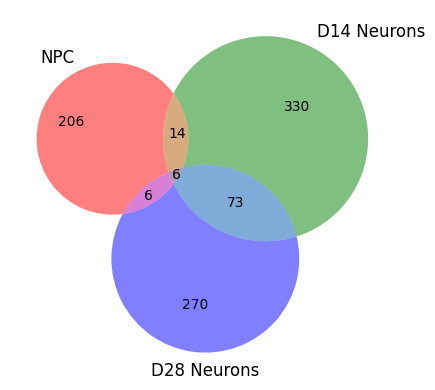

In [61]:
venn3(subsets = (len(NPC_only), len(D14_only), len(NPC_D14_shared), len(D28_only), len(NPC_D28_shared), 
                 len(D14_D28_shared), len(all_shared)), set_labels = ('NPC', 'D14 Neurons', 'D28 Neurons'), alpha = 0.5)
#venn3(subsets = (20, 10, 12, 10, 9, 4, 3), set_labels = ('Group A', 'Group B', 'Group C'), alpha = 0.5);

In [62]:
# What are the shared features?

all_shared

['Nuclei_RadialDistribution_MeanFrac_Mito_3of4',
 'Nuclei_Texture_AngularSecondMoment_Brightfield_20_01_256',
 'Nuclei_Texture_AngularSecondMoment_Mito_20_00_256',
 'Nuclei_Texture_DifferenceVariance_Mito_20_00_256',
 'Nuclei_Texture_DifferenceVariance_Mito_20_01_256',
 'Nuclei_Texture_DifferenceVariance_Mito_20_03_256']

## What do the shared differential features look like?

In [63]:
# Nuclei_Texture_AngularSecondMoment_Mito_20_00_256

D28_ctrl_mito = D28_ctrl['Nuclei_Texture_AngularSecondMoment_Mito_20_00_256']
D28_case_mito = D28_case['Nuclei_Texture_AngularSecondMoment_Mito_20_00_256']
D14_ctrl_mito = D14_ctrl['Nuclei_Texture_AngularSecondMoment_Mito_20_00_256']
D14_case_mito = D14_case['Nuclei_Texture_AngularSecondMoment_Mito_20_00_256']
NPC_ctrl_mito = NPC_ctrl['Nuclei_Texture_AngularSecondMoment_Mito_20_00_256']
NPC_case_mito = NPC_case['Nuclei_Texture_AngularSecondMoment_Mito_20_00_256']

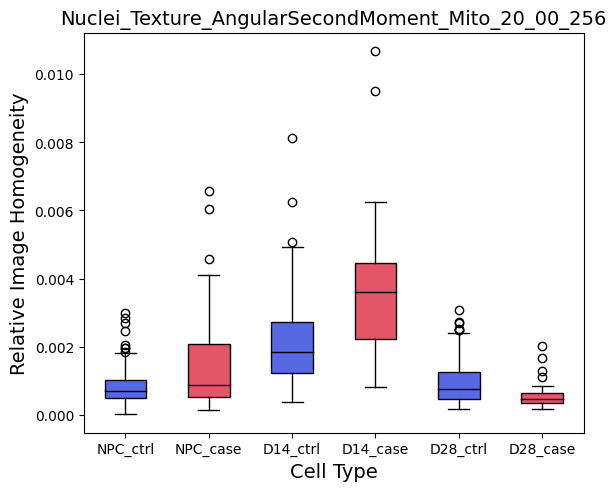

In [64]:
mito_data = [NPC_ctrl_mito, NPC_case_mito, D14_ctrl_mito, D14_case_mito, D28_ctrl_mito, D28_case_mito]
cell_labels = ['NPC_ctrl', 'NPC_case', 'D14_ctrl', 'D14_case', 'D28_ctrl', 'D28_case']
fig = plt.figure(figsize =(5, 4))
 
# Creating axes instance
ax = fig.add_axes([0, 0, 1, 1])
 
# Creating plot
bp = ax.boxplot(mito_data, labels = cell_labels, patch_artist=True)
plt.title('Nuclei_Texture_AngularSecondMoment_Mito_20_00_256', fontsize= 14)
ax.set_xticklabels(ax.get_xticklabels(), fontsize = 10)
plt.xlabel('Cell Type', fontsize = 14)
plt.ylabel('Relative Image Homogeneity', fontsize = 14)

for median in bp['medians']: median.set(color ='black') 
    
colors = ['#5668E2', '#E25668', '#5668E2', '#E25668', '#5668E2', '#E25668']
for bplot in bp:
    for patch, color in zip(bp['boxes'], colors):
        patch.set_facecolor(color)

# show plot
plt.show()

In [65]:
# Nuclei_RadialDistribution_MeanFrac_Mito_3of4'
D28_ctrl_rad = D28_ctrl['Nuclei_RadialDistribution_MeanFrac_Mito_3of4']
D28_case_rad = D28_case['Nuclei_RadialDistribution_MeanFrac_Mito_3of4']
D14_ctrl_rad = D14_ctrl['Nuclei_RadialDistribution_MeanFrac_Mito_3of4']
D14_case_rad = D14_case['Nuclei_RadialDistribution_MeanFrac_Mito_3of4']
NPC_ctrl_rad = NPC_ctrl['Nuclei_RadialDistribution_MeanFrac_Mito_3of4']
NPC_case_rad = NPC_case['Nuclei_RadialDistribution_MeanFrac_Mito_3of4']

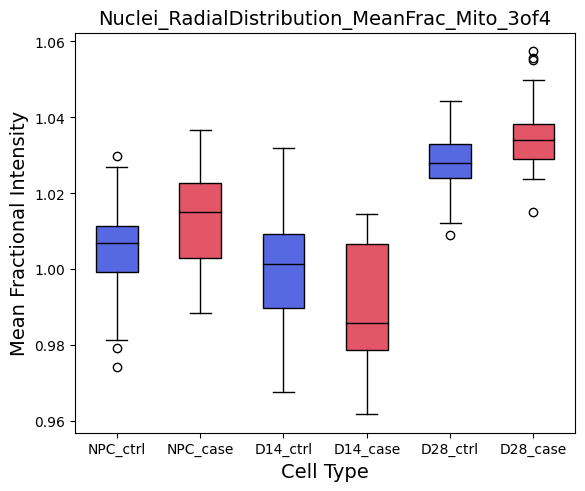

In [66]:
rad_data = [NPC_ctrl_rad, NPC_case_rad, D14_ctrl_rad, D14_case_rad, D28_ctrl_rad, D28_case_rad]
cell_labels = ['NPC_ctrl', 'NPC_case', 'D14_ctrl', 'D14_case', 'D28_ctrl', 'D28_case']
fig = plt.figure(figsize =(5, 4))
 
# Creating axes instance
ax = fig.add_axes([0, 0, 1, 1])
 
# Creating plot
bp = ax.boxplot(rad_data, labels = cell_labels, patch_artist=True)
plt.title('Nuclei_RadialDistribution_MeanFrac_Mito_3of4', fontsize= 14)
ax.set_xticklabels(ax.get_xticklabels(), fontsize = 10)
plt.xlabel('Cell Type', fontsize = 14)
plt.ylabel('Mean Fractional Intensity', fontsize = 14)

for median in bp['medians']: median.set(color ='black') 
    
colors = ['#5668E2', '#E25668', '#5668E2', '#E25668', '#5668E2', '#E25668']
for bplot in bp:
    for patch, color in zip(bp['boxes'], colors):
        patch.set_facecolor(color)

# show plot
plt.show()

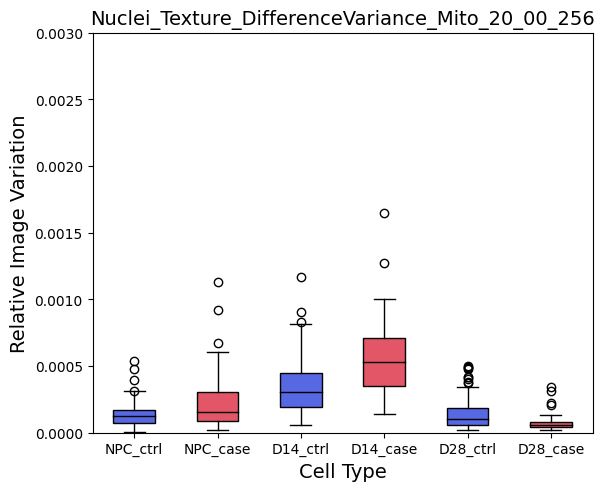

In [67]:
# Nuclei_Texture_DifferenceVariance_Mito_20_00_256
D28_ctrl_tex0 = D28_ctrl['Nuclei_Texture_DifferenceVariance_Mito_20_00_256']
D28_case_tex0 = D28_case['Nuclei_Texture_DifferenceVariance_Mito_20_00_256']
D14_ctrl_tex0 = D14_ctrl['Nuclei_Texture_DifferenceVariance_Mito_20_00_256']
D14_case_tex0 = D14_case['Nuclei_Texture_DifferenceVariance_Mito_20_00_256']
NPC_ctrl_tex0 = NPC_ctrl['Nuclei_Texture_DifferenceVariance_Mito_20_00_256']
NPC_case_tex0 = NPC_case['Nuclei_Texture_DifferenceVariance_Mito_20_00_256']

tex0_data = [NPC_ctrl_tex0, NPC_case_tex0, D14_ctrl_tex0, D14_case_tex0, D28_ctrl_tex0, D28_case_tex0]
cell_labels = ['NPC_ctrl', 'NPC_case', 'D14_ctrl', 'D14_case', 'D28_ctrl', 'D28_case']
fig = plt.figure(figsize =(5, 4))
 
# Creating axes instance
ax = fig.add_axes([0, 0, 1, 1])
 
# Creating plot
bp = ax.boxplot(tex0_data, labels = cell_labels, patch_artist=True)
plt.title('Nuclei_Texture_DifferenceVariance_Mito_20_00_256', fontsize= 14)
ax.set_xticklabels(ax.get_xticklabels(), fontsize = 10)
plt.xlabel('Cell Type', fontsize = 14)
plt.ylabel('Relative Image Variation', fontsize = 14)
plt.ylim(0, 0.0030)

for median in bp['medians']: median.set(color ='black') 
    
colors = ['#5668E2', '#E25668', '#5668E2', '#E25668', '#5668E2', '#E25668']
for bplot in bp:
    for patch, color in zip(bp['boxes'], colors):
        patch.set_facecolor(color)

# show plot
plt.show()

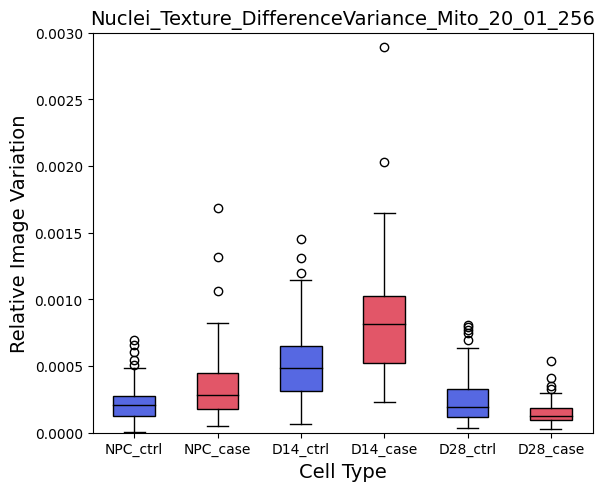

In [68]:
# Nuclei_Texture_DifferenceVariance_Mito_20_01_256'
D28_ctrl_tex1 = D28_ctrl['Nuclei_Texture_DifferenceVariance_Mito_20_01_256']
D28_case_tex1 = D28_case['Nuclei_Texture_DifferenceVariance_Mito_20_01_256']
D14_ctrl_tex1 = D14_ctrl['Nuclei_Texture_DifferenceVariance_Mito_20_01_256']
D14_case_tex1 = D14_case['Nuclei_Texture_DifferenceVariance_Mito_20_01_256']
NPC_ctrl_tex1 = NPC_ctrl['Nuclei_Texture_DifferenceVariance_Mito_20_01_256']
NPC_case_tex1 = NPC_case['Nuclei_Texture_DifferenceVariance_Mito_20_01_256']

tex1_data = [NPC_ctrl_tex1, NPC_case_tex1, D14_ctrl_tex1, D14_case_tex1, D28_ctrl_tex1, D28_case_tex1]
cell_labels = ['NPC_ctrl', 'NPC_case', 'D14_ctrl', 'D14_case', 'D28_ctrl', 'D28_case']
fig = plt.figure(figsize =(5, 4))
 
# Creating axes instance
ax = fig.add_axes([0, 0, 1, 1])
 
# Creating plot
bp = ax.boxplot(tex1_data, labels = cell_labels, patch_artist=True)
plt.title('Nuclei_Texture_DifferenceVariance_Mito_20_01_256', fontsize= 14)
plt.ylim(0, 0.0030)
ax.set_xticklabels(ax.get_xticklabels(), fontsize = 10)
plt.xlabel('Cell Type', fontsize = 14)
plt.ylabel('Relative Image Variation', fontsize = 14)

for median in bp['medians']: median.set(color ='black') 
    
colors = ['#5668E2', '#E25668', '#5668E2', '#E25668', '#5668E2', '#E25668']
for bplot in bp:
    for patch, color in zip(bp['boxes'], colors):
        patch.set_facecolor(color)

# show plot
plt.show()

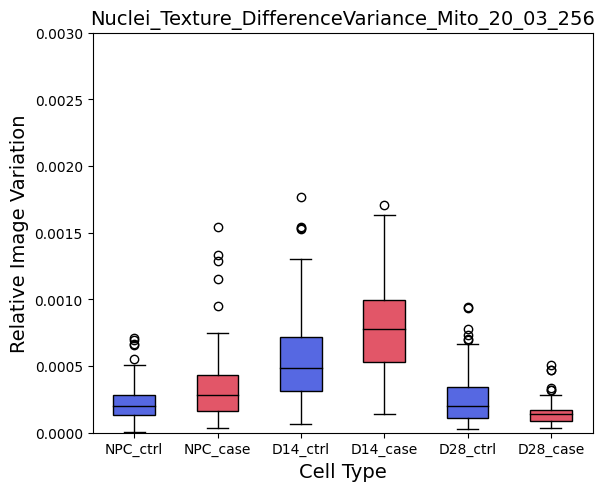

In [69]:
# Nuclei_Texture_DifferenceVariance_Mito_20_03_256'
D28_ctrl_tex3 = D28_ctrl['Nuclei_Texture_DifferenceVariance_Mito_20_03_256']
D28_case_tex3 = D28_case['Nuclei_Texture_DifferenceVariance_Mito_20_03_256']
D14_ctrl_tex3 = D14_ctrl['Nuclei_Texture_DifferenceVariance_Mito_20_03_256']
D14_case_tex3 = D14_case['Nuclei_Texture_DifferenceVariance_Mito_20_03_256']
NPC_ctrl_tex3 = NPC_ctrl['Nuclei_Texture_DifferenceVariance_Mito_20_03_256']
NPC_case_tex3 = NPC_case['Nuclei_Texture_DifferenceVariance_Mito_20_03_256']

tex3_data = [NPC_ctrl_tex3, NPC_case_tex3, D14_ctrl_tex3, D14_case_tex3, D28_ctrl_tex3, D28_case_tex3]
cell_labels = ['NPC_ctrl', 'NPC_case', 'D14_ctrl', 'D14_case', 'D28_ctrl', 'D28_case']
fig = plt.figure(figsize =(5, 4))
 
# Creating axes instance
ax = fig.add_axes([0, 0, 1, 1])
 
# Creating plot
bp = ax.boxplot(tex3_data, labels = cell_labels, patch_artist=True)
plt.title('Nuclei_Texture_DifferenceVariance_Mito_20_03_256', fontsize= 14)
plt.ylim(0, 0.0030)
ax.set_xticklabels(ax.get_xticklabels(), fontsize = 10)
plt.xlabel('Cell Type', fontsize = 14)
plt.ylabel('Relative Image Variation', fontsize = 14)

for median in bp['medians']: median.set(color ='black') 
    
colors = ['#5668E2', '#E25668', '#5668E2', '#E25668', '#5668E2', '#E25668']
for bplot in bp:
    for patch, color in zip(bp['boxes'], colors):
        patch.set_facecolor(color)

# show plot
plt.show()

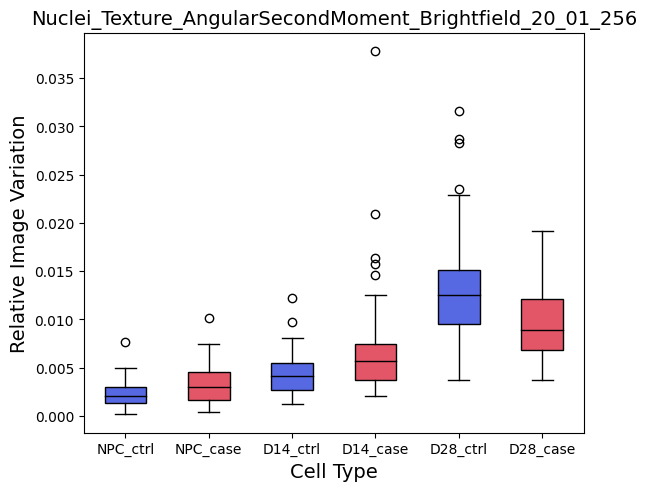

In [70]:
# Nuclei_Texture_AngularSecondMoment_Brightfield_20_01_256'
D28_ctrl_br = D28_ctrl['Nuclei_Texture_AngularSecondMoment_Brightfield_20_01_256']
D28_case_br = D28_case['Nuclei_Texture_AngularSecondMoment_Brightfield_20_01_256']
D14_ctrl_br = D14_ctrl['Nuclei_Texture_AngularSecondMoment_Brightfield_20_01_256']
D14_case_br = D14_case['Nuclei_Texture_AngularSecondMoment_Brightfield_20_01_256']
NPC_ctrl_br = NPC_ctrl['Nuclei_Texture_AngularSecondMoment_Brightfield_20_01_256']
NPC_case_br = NPC_case['Nuclei_Texture_AngularSecondMoment_Brightfield_20_01_256']

br_data = [NPC_ctrl_br, NPC_case_br, D14_ctrl_br, D14_case_br, D28_ctrl_br, D28_case_br]
cell_labels = ['NPC_ctrl', 'NPC_case', 'D14_ctrl', 'D14_case', 'D28_ctrl', 'D28_case']
fig = plt.figure(figsize =(5, 4))
 
# Creating axes instance
ax = fig.add_axes([0, 0, 1, 1])
 
# Creating plot
bp = ax.boxplot(br_data, labels = cell_labels, patch_artist=True)
plt.title('Nuclei_Texture_AngularSecondMoment_Brightfield_20_01_256', fontsize= 14)
ax.set_xticklabels(ax.get_xticklabels(), fontsize = 10)
plt.xlabel('Cell Type', fontsize = 14)
plt.ylabel('Relative Image Variation', fontsize = 14)

for median in bp['medians']: median.set(color ='black') 
    
colors = ['#5668E2', '#E25668', '#5668E2', '#E25668', '#5668E2', '#E25668']
for bplot in bp:
    for patch, color in zip(bp['boxes'], colors):
        patch.set_facecolor(color)

# show plot
plt.show()